In [1]:
import lxml
from absl import app, flags, logging
from absl.flags import FLAGS
import numpy as np
import tensorflow as tf
from tqdm import tqdm

from chars_cut import cut
from chars_detect import detect
from chars_model import CModel
from generate_dataset_plate import parse_xml
from plate_detect import detect_and_cut_single_img, cut_plate
from tools.dataset_utils import generate_xml
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
import yolov3_tf2.dataset_chars as dataset
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
flags.DEFINE_string('image_root_path', './data/Plate_dataset/AC/train/jpeg/', 'path to input image')
flags.DEFINE_string('xml_in_root_path', './data/Plate_dataset/AC/train/xml/', 'path to input xml')
flags.DEFINE_string('xml_out_root_path', './data/Plate_dataset/AC/test/xml_pred/', 'path to output xml')
flags.DEFINE_string('classifier_classes', './data/chars_data.names', 'path to classes file')
flags.DEFINE_string('classifier_weights', './chars_checkpoints/resnet101v2_train_98.tf', 'path to weights file')
flags.DEFINE_integer('classifier_size', 32, 'size of each character should be resize to')

app._run_init(['cut'], app.parse_flags_with_usage)

['cut']

In [3]:
class_map_inv = {idx: name for idx, name in enumerate(open(FLAGS.classifier_classes).read().splitlines())}
class_num = len(class_map_inv)
model = CModel(size=FLAGS.classifier_size, class_num=class_num, weights=None)
model.load_weights(FLAGS.classifier_weights).expect_partial()

In [4]:
xmls = [filename for filename in os.listdir(FLAGS.xml_in_root_path) if filename.endswith('.xml')]

In [750]:
xml = '358.xml'
annotation_xml = lxml.etree.fromstring(open(os.path.join(FLAGS.xml_in_root_path, xml)).read())
annotation = parse_xml(annotation_xml)['annotation']
img_file_name = annotation['filename']
img_path = os.path.join(FLAGS.image_root_path, img_file_name)
img_raw = tf.image.decode_jpeg(open(img_path, 'rb').read())
xmin = int(annotation['object'][0]['bndbox']['xmin'])
ymin = int(annotation['object'][0]['bndbox']['ymin'])
xmax = int(annotation['object'][0]['bndbox']['xmax'])
ymax = int(annotation['object'][0]['bndbox']['ymax'])
img_raw = cut_plate(img_raw, xmin, ymin, xmax, ymax)

In [751]:
def bw_process(img, a=199, b=6):
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
    equ = cv2.equalizeHist(img_grey)
    img_bw = cv2.adaptiveThreshold(equ, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, a, b)
    #img_bw = cv2.adaptiveThreshold(equ, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 11)
    img_bw = 255 - img_bw
    return img_bw

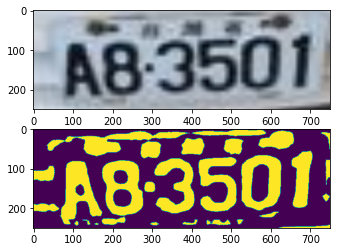

In [752]:
img_bw = bw_process(img_raw,a=199,b=30)
plt.subplot(2,1,1).imshow(img_raw)
plt.subplot(2,1,2).imshow(img_bw)

In [753]:
img_bw.shape

(250, 750)

In [754]:
heng = np.sum(img_bw, axis=1).astype(np.int32)

In [755]:
def rush_forward(pos, array, step):
    while pos+step < array.shape[0] and array[pos] > array[pos+step]:
        pos += step
    return pos

def rush_backward(pos, array, step):
    while pos-step>=0 and array[pos-step] < array[pos]:
        pos -= step
    return pos

def rush_b(ret_l, ret_r, array, step=1):
    ret_l = rush_backward(ret_l, array, step)
    ret_l = rush_forward(ret_l, array, step)
    ret_r = rush_forward(ret_r, array, step)
    ret_r = rush_backward(ret_r, array, step)
    return ret_l, ret_r
    
def find_half_bogu_area(array, lmb=6):
    #array = np.diff(np.diff(array))
    #l, r = np.min(array), np.max(array)
    mid = l = r = int(np.max(array) / lmb)
    r += 10
    ret_l, ret_r = 0, array.shape[0] - 1
    while l < r:
        mid = (l+r+1) // 2
        tmp = np.diff(array>mid)
        poses = np.argwhere(tmp==1).flatten()
        if poses.shape[0] < 2:
            r = mid - 1
            continue
        d = np.diff(poses)
        pos = d.argmax()
        tmp_l, tmp_r = rush_b(poses[pos], poses[pos+1], array)
        if d[pos] > array.shape[0] * 0.4:
            ret_l, ret_r = tmp_l, tmp_r
            l = mid
        else:
            r = mid - 1
            pass
        pass
    print('MID:', l)
    print(ret_l, ret_r)
    ret_l, ret_r = rush_b(ret_l, ret_r, array)
    print(ret_l, ret_r)
    return ret_l, ret_r

MID: 12250
2 218
2 218
MID: 16330
65 215
65 215


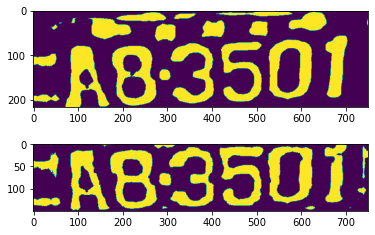

In [756]:
img_bw = bw_process(img_raw,a=199, b=48)
l1, r1 = find_half_bogu_area(np.sum(img_bw, axis=1).astype(np.int32), lmb=8)
img_bw = img_bw[l1:r1]
plt.subplot(2,1,1).imshow(img_bw)
l2, r2 = find_half_bogu_area(np.sum(img_bw, axis=1).astype(np.int32), lmb=6)
tmp = img_raw[l1:r1]
tmp = tmp[l2:r2]
img_bw_heng = bw_process(tmp,a=77,b=18)
plt.subplot(2,1,2).imshow(img_bw_heng)

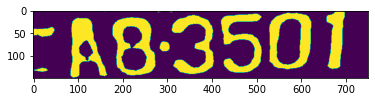

In [757]:
img_bw_heng = bw_process(tmp,a=199,b=48)
plt.imshow(img_bw_heng)

In [758]:
tmp = np.argwhere(np.sum(img_bw_heng, axis=0)==0).flatten()
print(img_bw_heng.shape)

L = max([x for x in tmp if x < img_bw_heng.shape[1]//15], default=0)
R = min([x for x in tmp if (img_bw_heng.shape[1]-x) < img_bw_heng.shape[1]//15], default=img_bw_heng.shape[1]-1)
print(L,R)

(150, 750)
49 701


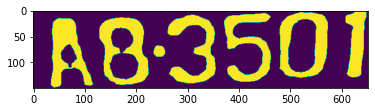

In [759]:
img_bw_heng=img_bw_heng[:,L:R]
plt.imshow(img_bw_heng)

In [760]:
import scipy.stats as st

def gkern(kernlen, sigma=None):
    """Returns a 2D Gaussian kernel."""
    if sigma is None:
        sigma = np.sqrt(kernlen/5)
    x = np.linspace(-sigma, sigma, kernlen)
    return st.norm.pdf(x)*2

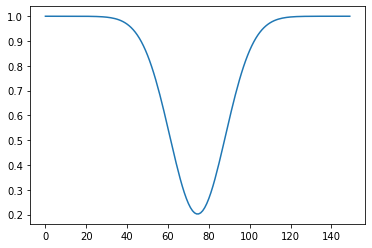

In [761]:
height=img_bw_heng.shape[0]
ker = 1-gkern(height)
#ker = np.ones(img_bw_heng.shape[0])
plt.plot(ker)

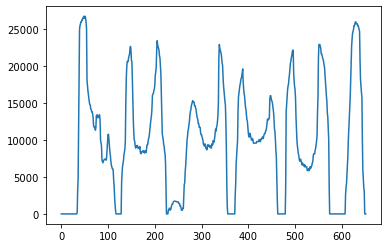

In [762]:
zong=ker@img_bw_heng
plt.plot(zong)

0


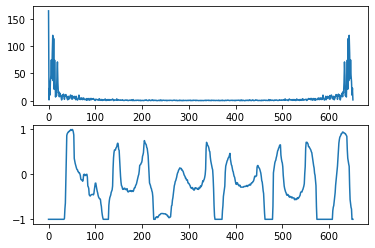

In [763]:
mx = np.max(zong)
mi = np.min(zong)
tmp = (zong - mi) / (mx - mi) * 2 - 1
fft = np.fft.fft(tmp)
plt.subplot(2,1,1).plot(np.abs(fft))
plt.subplot(2,1,2).plot(tmp)
print(np.argmax(np.abs(fft)))

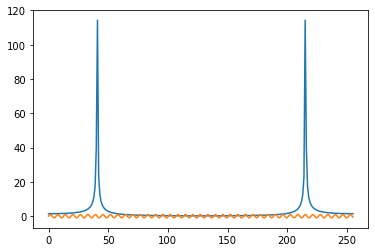

In [764]:
t = np.arange(256)
sp = np.fft.fft(np.sin(t))
freq = np.fft.fftfreq(zong.shape[0])
plt.plot(np.abs(sp))
plt.plot(np.sin(t))

In [765]:
#plt.plot(np.sum(img_bw_heng, axis=0))

In [766]:
def get_poses_sizez(mid, zong):
    poses = np.argwhere(zong<mid).flatten()
    poses = np.hstack([0, poses, zong.shape[0]-1])
    sizez = sorted(enumerate(np.diff(poses)), key=lambda x: -x[1])
    return poses, sizez

In [767]:
def get_var(mid, zong):
    poses, sizez = get_poses_sizez(mid, zong)
    if len(sizez) < 6:
        return np.inf
    sizez = sizez[:6]
    mids = []
    delta = (sizez[0][1] + sizez[1][1])/2
    for i,j in sorted(sizez, key=lambda x: x[0]):
        mids.append((poses[i+1] + poses[i]) / 2)
    if delta * 6 < zong.shape[0] * 0.7:
        return np.inf
    fff = np.diff(mids)
    mid_var = np.square(fff - np.mean(fff)).sum()
    fff = np.array([b for a,b in sizez])
    sizez_var = np.square(fff - delta).sum()
    return mid_var * 0.2 + sizez_var *0.8

In [768]:
maximum = zong.max()
ans = (np.inf, np.inf)
for i in range(100):
    mid = maximum * i / 100
    cur = get_var(mid, zong)
    if cur < ans[0]:
        ans = (cur, mid)


In [769]:
poses, sizez = get_poses_sizez(ans[1], zong)
sizez = sizez[:6]
lrs = []
delta = (sizez[0][1] + sizez[1][1])/2
for i,j in sorted(sizez, key=lambda x: x[0]):
    l,r = rush_b(poses[i], poses[i+1], zong, step=10)
    if r-l < delta*0.7:
        mid = (l+r)/2
        l,r = max(0,int(mid-delta*0.35)), min(int(mid+delta*0.35),zong.shape[0]-1)
        l,r = rush_b(l, r, array=zong, step=8)
    lrs.append((l,r))
    #lrs.append((poses[i] ,poses[i+1]))

34 116
128 225
261 355
371 463
479 574
607 649


(2628.4400000000005, 1068.9257524066018) [(48, 97), (100, 95), (66, 94), (83, 92), (35, 82), (134, 42)]
2628.4400000000005


[(24, 126), (128, 225), (261, 365), (371, 463), (479, 574), (594, 651)]


<ipython-input-771-765e8a285e4e>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 1).plot(np.ones(img_bw_heng.shape[1]) * ans[1])


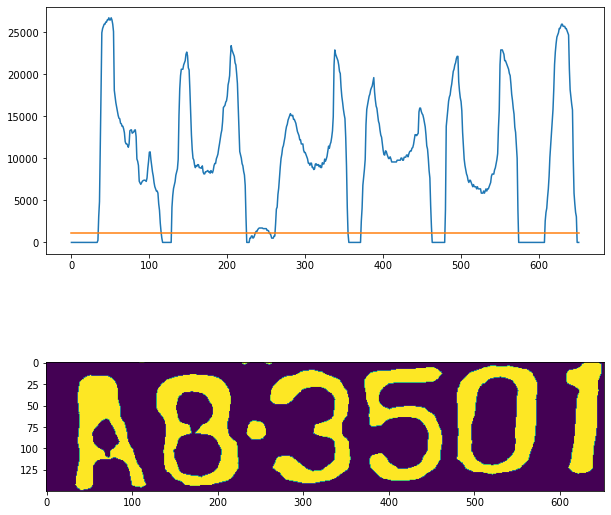

In [771]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1).plot(zong)
plt.subplot(2, 1, 1).plot(np.ones(img_bw_heng.shape[1]) * ans[1])
plt.subplot(2, 1, 2).imshow(img_bw_heng)
print(lrs)

In [772]:
#chrs = [img_bw_heng[:,max(int(mid-delta/2), 0):min(int(mid+delta/2), img_bw_heng.shape[1])] for mid in mids]
chrs = [img_bw_heng[:,l:r] for l,r in lrs]


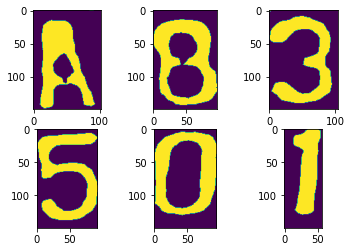

In [773]:
for idx, img in enumerate(chrs):
    plt.subplot(2, 3, idx+1).imshow(img)
    #plt.subplot(2, 3, idx+1).imshow(img_bw_heng[:,idx*img_bw_heng.shape[1]//6:(idx+1)*img_bw_heng.shape[1]//6])
    pass
plt.show()

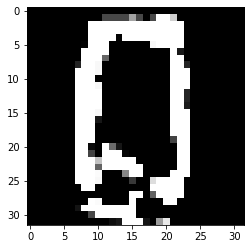

In [698]:
tmp = tf.image.resize_with_pad(tf.expand_dims(chrs[5], axis=2), 32, 32, antialias=False)
plt.imshow(tmp.numpy()[:,:,0], cmap='gray')